In [12]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MmhcEstimator
from pgmpy.estimators import BDeuScore
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BayesianEstimator
from pgmpy.factors.discrete.CPD import TabularCPD

import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import random

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Построение модели 

In [4]:
# Создаем вершины
bayesNet = BayesianNetwork()
bayesNet.add_node("Burglary")
bayesNet.add_node("Earthqk")
bayesNet.add_node("Alarm")
bayesNet.add_node("John calls")
bayesNet.add_node("Mary calls")


# Создаем грани
bayesNet.add_edge("Burglary", "Alarm")
bayesNet.add_edge("Earthqk", "Alarm")
bayesNet.add_edge("Alarm", "John calls")
bayesNet.add_edge("Alarm", "Mary calls")


In [5]:
#Добавление вероятностей
cpd_B = TabularCPD('Burglary', 2, values=[[.999], [.001]])
cpd_E = TabularCPD('Earthqk', 2, values=[[.998], [.002]])

cpd_A = TabularCPD('Alarm', 2, values=[[0.999, .71, .06, .05], [.001, .29, .94, .95]],
                   evidence=['Burglary', 'Earthqk'], evidence_card=[2, 2])


cpd_J = TabularCPD('John calls', 2, values=[[0.95, .1], [.05, .9]],
                   evidence=['Alarm'], evidence_card=[2])

cpd_M = TabularCPD('Mary calls', 2, values=[[0.99, .3], [.01, .7]],
                   evidence=['Alarm'], evidence_card=[2])



bayesNet.add_cpds(cpd_B, cpd_E,cpd_A, cpd_J, cpd_M)


In [6]:
bayesNet.check_model()
print("Model is correct.")


Model is correct.


In [7]:
solver = VariableElimination(bayesNet)


In [8]:
# Вероятность работы сигнализации
result = solver.query(variables=['Alarm'])
print(result)
print(f'Вероятность того, что сигнализация сработает = {result.values[1]}')

+----------+--------------+
| Alarm    |   phi(Alarm) |
+==========+==============+
| Alarm(0) |       0.9975 |
+----------+--------------+
| Alarm(1) |       0.0025 |
+----------+--------------+
Вероятность того, что сигнализация сработает = 0.0025164420000000002


In [9]:
# Вероятность работы сигнализации при землетрясении
result = solver.query(variables=['Alarm'], evidence={'Earthqk': 1})
print(result)
print(f'Вероятность того, что сигнализация сработает при землетрясении = {result.values[1]}')

+----------+--------------+
| Alarm    |   phi(Alarm) |
+==========+==============+
| Alarm(0) |       0.7093 |
+----------+--------------+
| Alarm(1) |       0.2907 |
+----------+--------------+
Вероятность того, что сигнализация сработает при землетрясении = 0.29066


In [10]:
# Вероятность работы сигнализации при взломе
result = solver.query(variables=['Alarm'], evidence={'Burglary': 1})
print(result)
print(f'Вероятность того, что сигнализация сработает при взломе = {result.values[1]}')

+----------+--------------+
| Alarm    |   phi(Alarm) |
+==========+==============+
| Alarm(0) |       0.0600 |
+----------+--------------+
| Alarm(1) |       0.9400 |
+----------+--------------+
Вероятность того, что сигнализация сработает при взломе = 0.94002


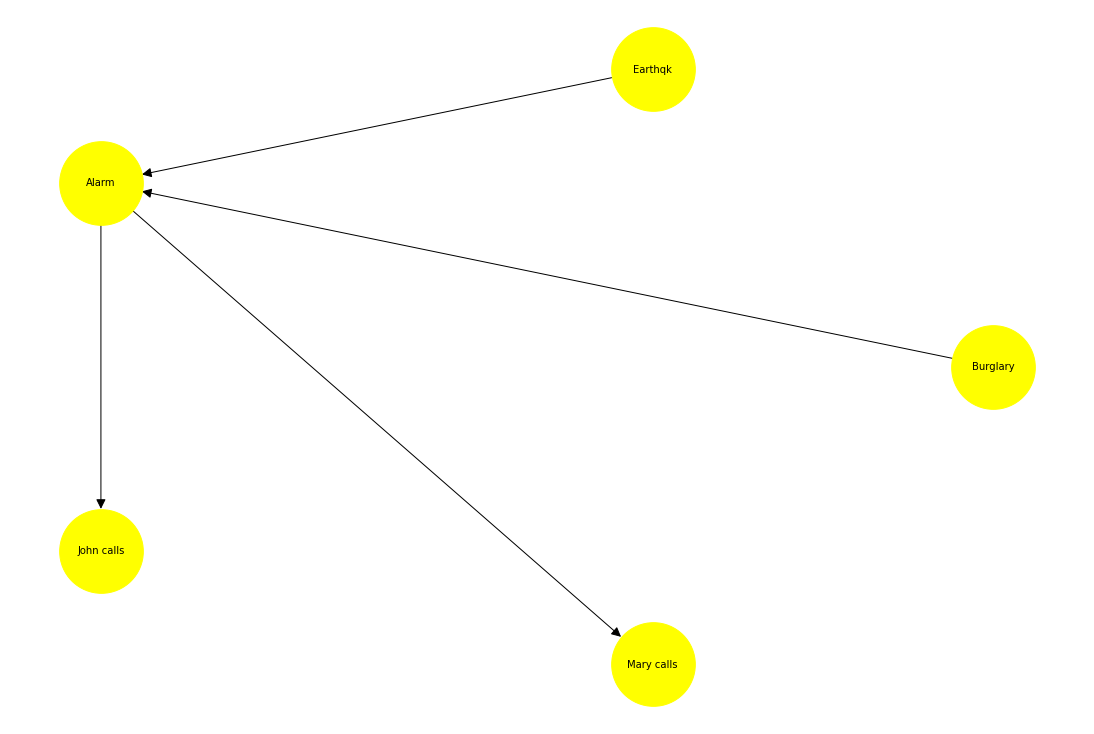

In [11]:
plt.figure(figsize=(15,10))
nx.draw_circular(solver.model, with_labels=True, arrowsize=20, node_size=7000, font_size=10,node_color='yellow')
plt.show()

### Генерация данных

In [52]:
def draw_graph(model):
    plt.figure(figsize=(15,10))
    nx.draw(model, pos=nx.circular_layout(model), with_labels=True,node_size=7000, font_size=10,node_color='red')
    plt.show()

In [53]:
def create_graph(df):
    graph=MmhcEstimator(df)
    skeleton=graph.mmpc(significance_level=0.0005)
    print(f'Связи между вершинами: {skeleton.edges()}')
    hc=HillClimbSearch(df)
    model=hc.estimate(white_list=skeleton.to_directed().edges(), scoring_method=BDeuScore(df), max_iter=100, epsilon=1e-6)
    print(f'Направление связей:{model.edges()}')
    draw_graph(model)


In [67]:
def generate_df(count):
    data_for_B=random.choices([1,0], [0.001, 0.999], k=count)
    data_for_E = random.choices([1,0], [0.002, 0.998], k=count)
    data_for_A=[]
    for i in range (0, count):
        if data_for_B[i]:
            if data_for_E[i]:
                data_for_A.append(random.choices([1,0], [0.95, 0.05])[0])
            else:
                data_for_A.append(random.choices([1,0], [0.94, 0.06])[0])
        else:
            if data_for_E[i]:
                data_for_A.append(random.choices([1,0], [0.29, 0.71])[0])
            else:
                data_for_A.append(random.choices([1,0], [0.001, 0.999])[0])
    data_for_J=[]
    for i in range(0, count):
        if data_for_A[i]:
            data_for_J.append(random.choices([1,0], [0.9, 0.1])[0])
        else:
            data_for_J.append(random.choices([1,0], [0.05, 0.95])[0])
            
    data_for_M=[]
    for i in range(0, count):
        if data_for_A[i]:
            data_for_M.append(random.choices([1,0], [0.7, 0.3])[0])
        else:
            data_for_M.append(random.choices([1,0], [0.01, 0.99])[0])
    df=pd.DataFrame()
    df['Burglary']=data_for_B
    df['Earthqk']=data_for_E
    df['Alarm']=data_for_A
    df['John Call']=data_for_J
    df['Mary Call']=data_for_M
    
    return df

In [76]:
def print_full(cpd):
    backup=TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable=lambda self,x:x
    print(cpd)
    TabularCPD._truncate_strtable=backup


def bayesian_net(df):
    model=BayesianNetwork([('Burglary', 'Alarm'), ('Earthqk', 'Alarm'), ('Alarm', 'John Call'), ('Alarm', 'Mary Call')])
    model.fit(df, estimator=BayesianEstimator)
    cpds=model.get_cpds()
    for cpd in cpds:
        print_full(cpd) 
    


### 100.000 строк

In [77]:
# Создание датасета
df=generate_df(100000)

Связи между вершинами: [('Burglary', 'Mary Call'), ('Burglary', 'Alarm'), ('Earthqk', 'Alarm'), ('Alarm', 'John Call'), ('Alarm', 'Mary Call')]


  0%|          | 0/100 [00:00<?, ?it/s]

Направление связей:[('Burglary', 'Alarm'), ('Burglary', 'Mary Call'), ('Earthqk', 'Alarm'), ('Alarm', 'John Call'), ('Alarm', 'Mary Call')]


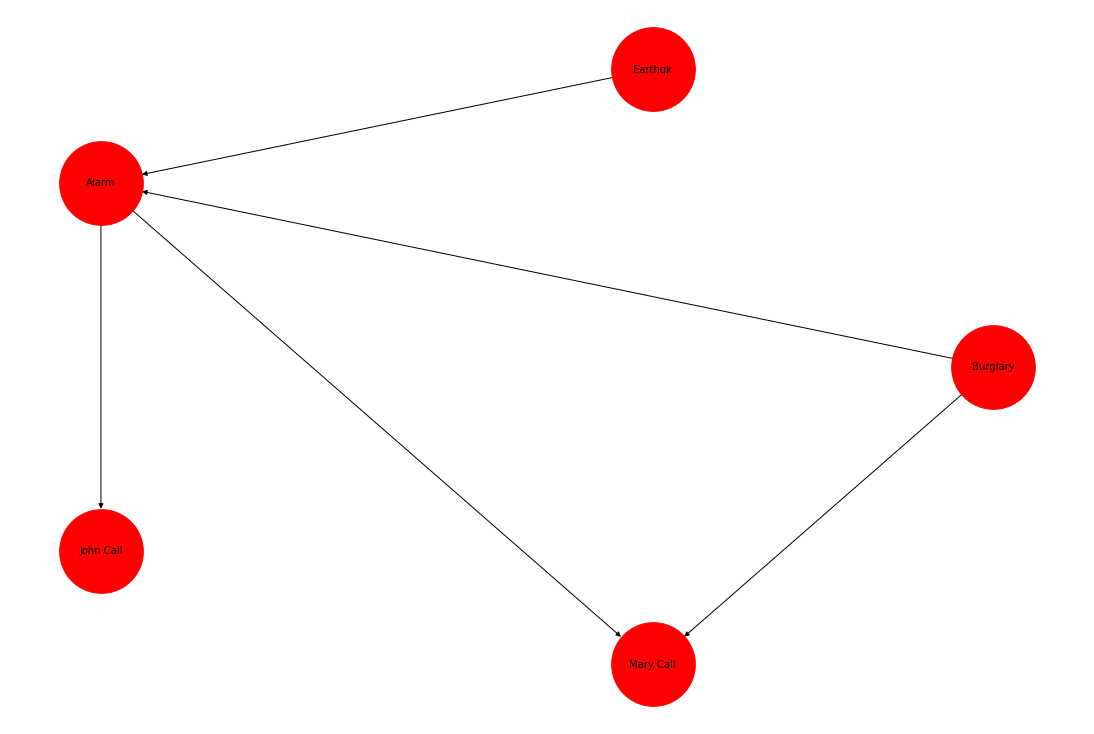

In [78]:
create_graph(df)

In [79]:
bayesian_net(df)

+-------------+------------+
| Burglary(0) | 0.998925   |
+-------------+------------+
| Burglary(1) | 0.00107495 |
+-------------+------------+
+----------+-----------------------+---------------------+---------------------+-------------+
| Burglary | Burglary(0)           | Burglary(0)         | Burglary(1)         | Burglary(1) |
+----------+-----------------------+---------------------+---------------------+-------------+
| Earthqk  | Earthqk(0)            | Earthqk(1)          | Earthqk(0)          | Earthqk(1)  |
+----------+-----------------------+---------------------+---------------------+-------------+
| Alarm(0) | 0.9989305121254598    | 0.7072409488139825  | 0.03411764705882353 | 0.5         |
+----------+-----------------------+---------------------+---------------------+-------------+
| Alarm(1) | 0.0010694878745401704 | 0.29275905118601747 | 0.9658823529411765  | 0.5         |
+----------+-----------------------+---------------------+---------------------+-------------+


### 200.000 строк

In [80]:
df=generate_df(200000)

Связи между вершинами: [('Burglary', 'Mary Call'), ('Burglary', 'Alarm'), ('Earthqk', 'Alarm'), ('Alarm', 'John Call'), ('Alarm', 'Mary Call')]


  0%|          | 0/100 [00:00<?, ?it/s]

Направление связей:[('Alarm', 'Mary Call'), ('Alarm', 'Burglary'), ('Alarm', 'Earthqk'), ('John Call', 'Alarm')]


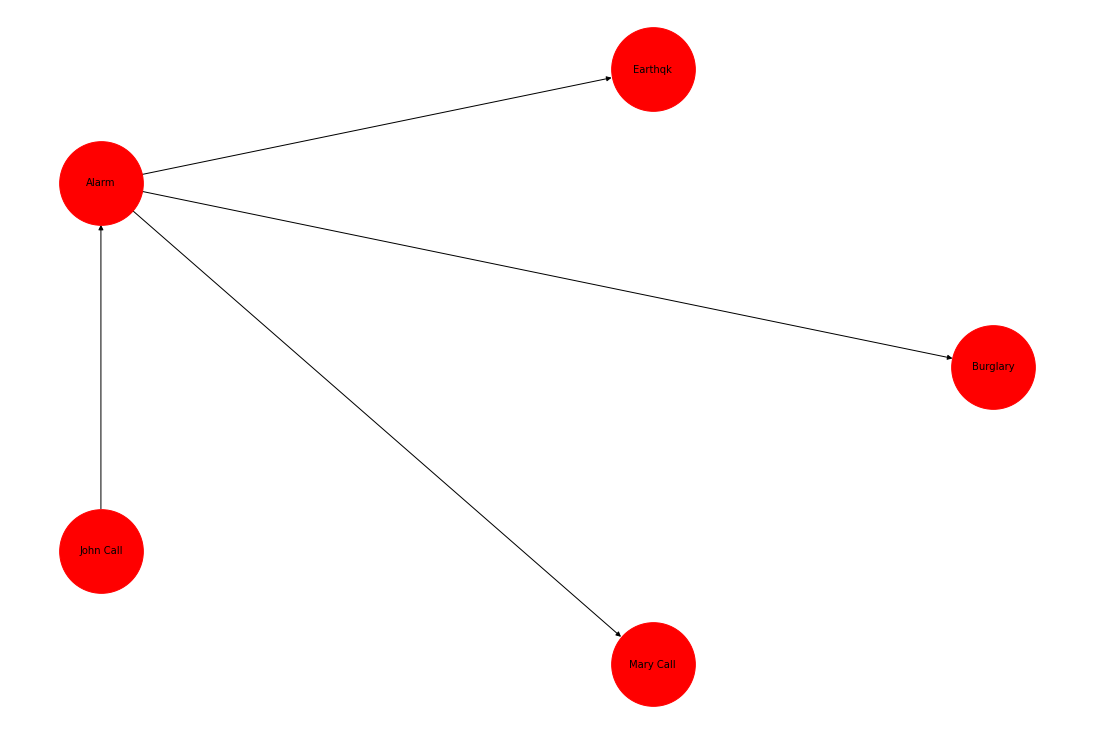

In [81]:
create_graph(df)

In [82]:
bayesian_net(df)

+-------------+-------------+
| Burglary(0) | 0.999133    |
+-------------+-------------+
| Burglary(1) | 0.000867478 |
+-------------+-------------+
+----------+----------------------+--------------------+---------------------+-------------+
| Burglary | Burglary(0)          | Burglary(0)        | Burglary(1)         | Burglary(1) |
+----------+----------------------+--------------------+---------------------+-------------+
| Earthqk  | Earthqk(0)           | Earthqk(1)         | Earthqk(0)          | Earthqk(1)  |
+----------+----------------------+--------------------+---------------------+-------------+
| Alarm(0) | 0.9990241780721469   | 0.7173064411190632 | 0.04426705370101597 | 0.5         |
+----------+----------------------+--------------------+---------------------+-------------+
| Alarm(1) | 0.000975821927853104 | 0.2826935588809369 | 0.9557329462989841  | 0.5         |
+----------+----------------------+--------------------+---------------------+-------------+
+------------

### 1.000.000 строк

In [83]:
df=generate_df(1000000)

Связи между вершинами: [('Burglary', 'Mary Call'), ('Burglary', 'Alarm'), ('Earthqk', 'Alarm'), ('Alarm', 'John Call'), ('Alarm', 'Mary Call')]


  0%|          | 0/100 [00:00<?, ?it/s]

Направление связей:[('Alarm', 'John Call'), ('Alarm', 'Burglary'), ('Alarm', 'Earthqk'), ('Mary Call', 'Alarm')]


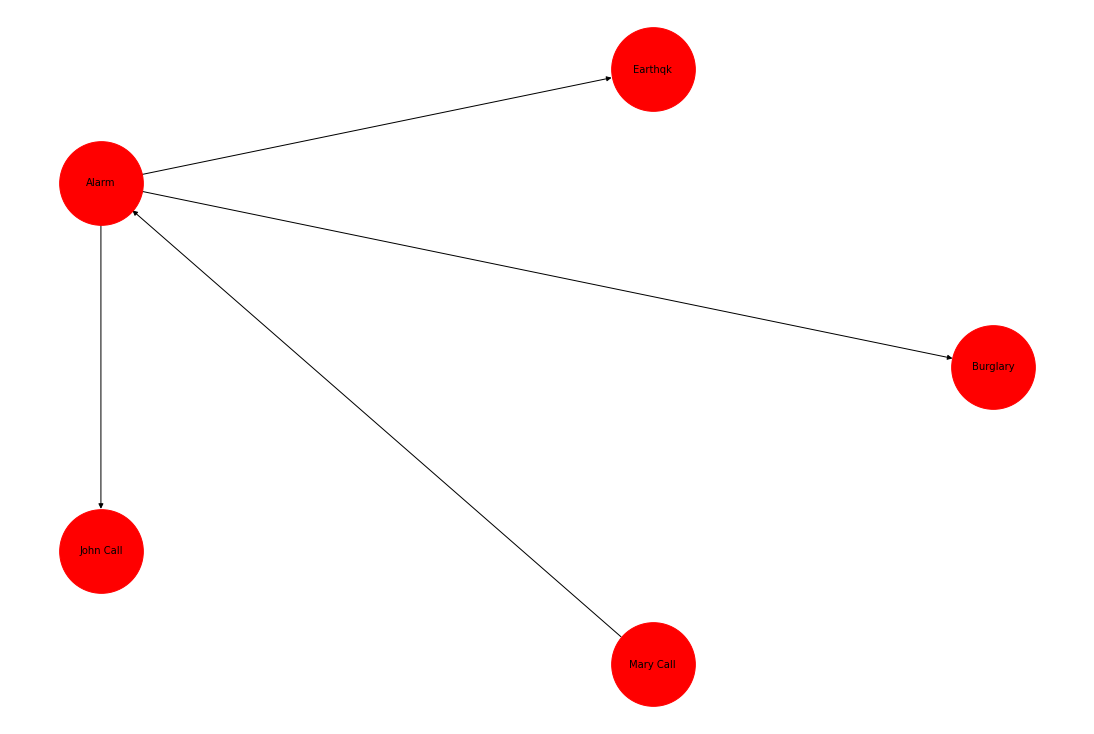

In [84]:
create_graph(df)

In [85]:
bayesian_net(df)

+-------------+-------------+
| Burglary(0) | 0.999009    |
+-------------+-------------+
| Burglary(1) | 0.000991495 |
+-------------+-------------+
+----------+-----------------------+--------------------+---------------------+---------------------+
| Burglary | Burglary(0)           | Burglary(0)        | Burglary(1)         | Burglary(1)         |
+----------+-----------------------+--------------------+---------------------+---------------------+
| Earthqk  | Earthqk(0)            | Earthqk(1)         | Earthqk(0)          | Earthqk(1)          |
+----------+-----------------------+--------------------+---------------------+---------------------+
| Alarm(0) | 0.9990174925688238    | 0.7069585312620362 | 0.06235770301037187 | 0.19230769230769232 |
+----------+-----------------------+--------------------+---------------------+---------------------+
| Alarm(1) | 0.0009825074311762133 | 0.2930414687379638 | 0.9376422969896281  | 0.8076923076923077  |
+----------+----------------------

### 2.000.000 строк

In [86]:
df=generate_df(2000000)

Связи между вершинами: [('Burglary', 'Mary Call'), ('Burglary', 'Alarm'), ('Earthqk', 'Alarm'), ('Alarm', 'John Call'), ('Alarm', 'Mary Call')]


  0%|          | 0/100 [00:00<?, ?it/s]

Направление связей:[('Alarm', 'Mary Call'), ('Alarm', 'Burglary'), ('Alarm', 'Earthqk'), ('John Call', 'Alarm')]


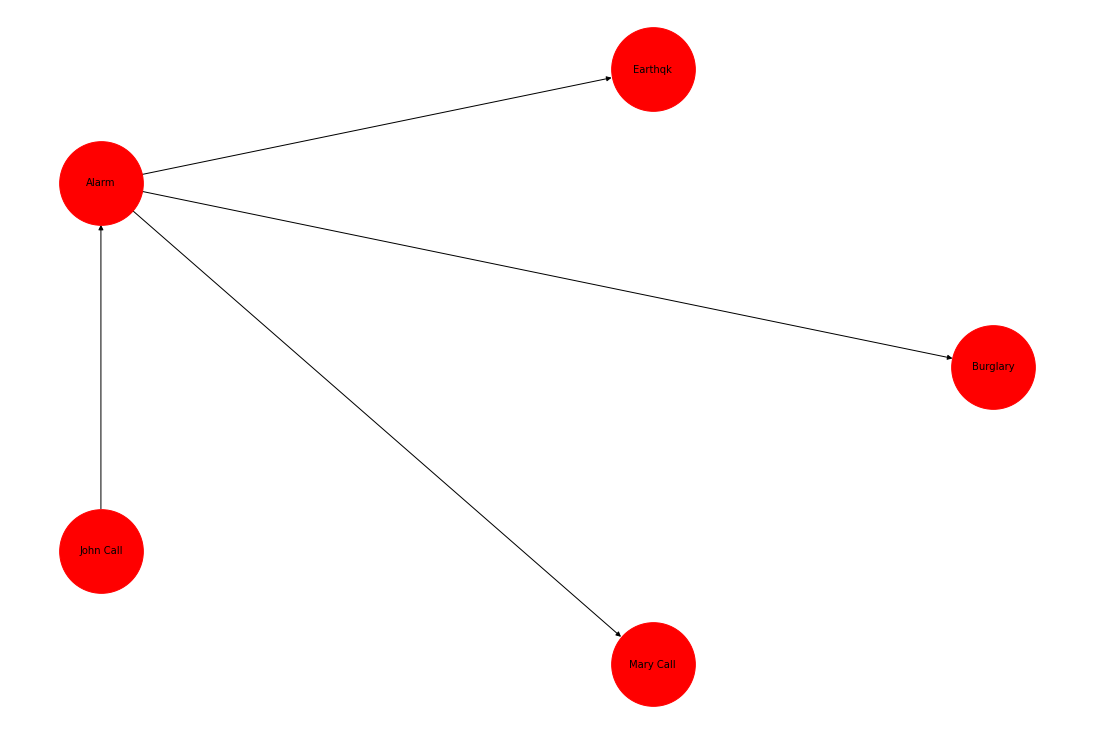

In [87]:
create_graph(df)

In [88]:
bayesian_net(df)

+-------------+------------+
| Burglary(0) | 0.998982   |
+-------------+------------+
| Burglary(1) | 0.00101775 |
+-------------+------------+
+----------+----------------------+--------------------+---------------------+---------------------+
| Burglary | Burglary(0)          | Burglary(0)        | Burglary(1)         | Burglary(1)         |
+----------+----------------------+--------------------+---------------------+---------------------+
| Earthqk  | Earthqk(0)           | Earthqk(1)         | Earthqk(0)          | Earthqk(1)          |
+----------+----------------------+--------------------+---------------------+---------------------+
| Alarm(0) | 0.9990062077381268   | 0.7051055783170501 | 0.06384681689447112 | 0.11904761904761904 |
+----------+----------------------+--------------------+---------------------+---------------------+
| Alarm(1) | 0.000993792261873194 | 0.2948944216829499 | 0.9361531831055289  | 0.8809523809523809  |
+----------+----------------------+------------